In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt
# Shows plots in jupyter notebook
#%matplotlib inline
import tensorflow 
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras import optimizers
import math
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_classif
import keras.callbacks
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
import joblib
from os.path import exists
from keras.models import load_model
from sklearn.utils import class_weight
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import schedules
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from keras.optimizers import schedules
from tensorflow.keras.callbacks import ModelCheckpoint
import joblib
from sklearn.model_selection import StratifiedShuffleSplit
import datetime


In [79]:
def plot_categorical_features(df, categorical_features, independent_variable,m):
    n= math.ceil(len(categorical_features)/m)
    for i, col in enumerate(categorical_features):
        plt.subplot(n, m, i+1)
        sns.countplot(x =categorical_features[i], data= df, hue= independent_variable)
        plt.title(categorical_features[i])
    plt.subplots_adjust(hspace=0.5)
    plt.show()

In [80]:
def plot_ordinal_features(df, ordinal_features, independent_variable):
    n = len(ordinal_features)
    f, axs = plt.subplots(n, 3,figsize=(20,20))
    for i, col in enumerate(ordinal_features):
        
        #bins = np.histogram_bin_edges(df[ordinal_features[i]], bins='auto')
        bins = np.histogram_bin_edges(df[ordinal_features[i]], bins='auto')
        sns.histplot(df[ordinal_features[i]],bins=bins, ax=axs[i,0])
        for ax in axs[i]:
            for p in ax.patches:
                x, w, h = p.get_x(), p.get_width(), p.get_height()
                if h > 0:
                    ax.text(x + w / 2, h, f'{h}\n', ha='center', va='center', size=8)
            ax.margins(y=0.07)
        axs[i, 0].set_title(ordinal_features[i])
        sns.histplot(data=df, x=ordinal_features[i], hue = independent_variable, ax=axs[i,1])
        axs[i, 1].set_title(ordinal_features[i])
        df1 = df.groupby([ordinal_features[i],independent_variable]).size().reset_index()
        df1.columns = [ordinal_features[i], independent_variable, 'count']
        df1 = df1.pivot(index=ordinal_features[i],columns=independent_variable,values='count')
        df1.iloc[:, 0] = df1.iloc[:, 0].fillna(0)
        df1['ratio'] = df1.iloc[:, 0] / (df1.iloc[:, 1] + df1.iloc[:, 0])
        sns.barplot(x = ordinal_features[i], y = 'ratio', data = df1.reset_index(), ax=axs[i,2])
        axs[i,2].set_title(f"ratio of {ordinal_features[i]}, not_canceled to canceled")
    plt.subplots_adjust(hspace=1)
    plt.show()

In [81]:
df = pd.read_csv("Daten\Hotel_Reservations.csv")

In [82]:
df.head().style.set_properties(**{'background-color': 'lightblue',
                           'color': 'black',
                           'border-color': 'darkblack'})

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.000000,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.680000,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.000000,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.000000,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.500000,0,Canceled


Create the test set with a Stratified Shuffle Split to keep the distribution of the classes

In [83]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df["booking_status"]):
    X_train = df.iloc[train_index]
    X_test = df.iloc[test_index]

## 3. Explore the data to gain insights:

### General Overview over the data

In [84]:
display(X_train.shape)
display(X_train.size)

(29020, 19)

551380

In [85]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29020 entries, 9078 to 29823
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            29020 non-null  object 
 1   no_of_adults                          29020 non-null  int64  
 2   no_of_children                        29020 non-null  int64  
 3   no_of_weekend_nights                  29020 non-null  int64  
 4   no_of_week_nights                     29020 non-null  int64  
 5   type_of_meal_plan                     29020 non-null  object 
 6   required_car_parking_space            29020 non-null  int64  
 7   room_type_reserved                    29020 non-null  object 
 8   lead_time                             29020 non-null  int64  
 9   arrival_year                          29020 non-null  int64  
 10  arrival_month                         29020 non-null  int64  
 11  arrival_date

5 object types
booking_ID is probably useless
booking_status is the independent variable

In [86]:
X_train.describe()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
count,29020.000000,29020.000000,29020.000000,29020.000000,29020.000000,29020.000000,29020.000000,29020.000000,29020.000000,29020.000000,29020.000000,29020.000000,29020.000000,29020.000000
mean,1.846623,0.104859,0.810855,2.203308,0.031496,85.127016,2017.820193,7.431978,15.580875,0.025775,0.022674,0.157960,103.533282,0.620331
std,0.518991,0.402785,0.871787,1.415096,0.174656,85.921809,0.384033,3.070065,8.728470,0.158467,0.368525,1.796362,35.147072,0.788429
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,0.000000,17.000000,2018.000000,5.000000,8.000000,0.000000,0.000000,0.000000,80.492500,0.000000
50%,2.000000,0.000000,1.000000,2.000000,0.000000,57.000000,2018.000000,8.000000,16.000000,0.000000,0.000000,0.000000,99.900000,0.000000
75%,2.000000,0.000000,2.000000,3.000000,0.000000,126.000000,2018.000000,10.000000,23.000000,0.000000,0.000000,0.000000,120.600000,1.000000
max,4.000000,10.000000,7.000000,17.000000,1.000000,443.000000,2018.000000,12.000000,31.000000,1.000000,13.000000,58.000000,540.000000,5.000000


In [87]:
X_train.nunique()

Booking_ID                              29020
no_of_adults                                5
no_of_children                              6
no_of_weekend_nights                        8
no_of_week_nights                          18
type_of_meal_plan                           4
required_car_parking_space                  2
room_type_reserved                          7
lead_time                                 349
arrival_year                                2
arrival_month                              12
arrival_date                               31
market_segment_type                         5
repeated_guest                              2
no_of_previous_cancellations                9
no_of_previous_bookings_not_canceled       56
avg_price_per_room                       3489
no_of_special_requests                      6
booking_status                              2
dtype: int64

avg_price_per_room seems to be the only true numerical value, others are categorical or ordinal
lead_time is an ordinal feature with a big range

In [88]:
X_train.isnull().mean()*100

Booking_ID                              0.0
no_of_adults                            0.0
no_of_children                          0.0
no_of_weekend_nights                    0.0
no_of_week_nights                       0.0
type_of_meal_plan                       0.0
required_car_parking_space              0.0
room_type_reserved                      0.0
lead_time                               0.0
arrival_year                            0.0
arrival_month                           0.0
arrival_date                            0.0
market_segment_type                     0.0
repeated_guest                          0.0
no_of_previous_cancellations            0.0
no_of_previous_bookings_not_canceled    0.0
avg_price_per_room                      0.0
no_of_special_requests                  0.0
booking_status                          0.0
dtype: float64

In [89]:
X_train["type_of_meal_plan"].value_counts()

Meal Plan 1     22241
Not Selected     4117
Meal Plan 2      2657
Meal Plan 3         5
Name: type_of_meal_plan, dtype: int64

In [90]:
X_train["room_type_reserved"].value_counts()

Room_Type 1    22498
Room_Type 4     4862
Room_Type 6      764
Room_Type 2      546
Room_Type 5      222
Room_Type 7      123
Room_Type 3        5
Name: room_type_reserved, dtype: int64

For type_of_meal_plan and room_type_reserved there are 5 cases in each that are different from the others
It would be interesting if they are the same 5 cases

In [91]:
X_train["market_segment_type"].value_counts()

Online           18610
Offline           8381
Corporate         1612
Complementary      314
Aviation           103
Name: market_segment_type, dtype: int64

Now i will divide the features into different feature lists to handle them faster later on

In [92]:
all_features = list(df.columns[0:-1])
numerical_features = ["avg_price_per_room", "lead_time"]
label = ["booking_status"]
categorical_features = [x for x in all_features if x not in numerical_features and not label]
low_count_categorical_features = ["type_of_meal_plan", "market_segment_type", "repeated_guest", "required_car_parking_space", "room_type_reserved"]
high_count_categorical_features =["no_of_week_nights", "no_of_previous_bookings_not_canceled", "no_of_adults", "no_of_children", "no_of_weekend_nights", "no_of_previous_cancellations", "no_of_special_requests"]
unencoded_categorical_features = ["type_of_meal_plan", "market_segment_type", "room_type_reserved"]


In [93]:
X_train["booking_status"].value_counts()

Not_Canceled    19512
Canceled         9508
Name: booking_status, dtype: int64

([<matplotlib.patches.Wedge at 0x2e9059a1730>,
 [Text(-0.5669614309335993, 0.9426318135060612, 'Not_Canceled'),
  Text(0.5669614309335992, -0.9426318135060612, 'Canceled')],
 [Text(-0.30925168960014504, 0.5141628073669424, '67.2%'),
  Text(0.309251689600145, -0.5141628073669424, '32.8%')])

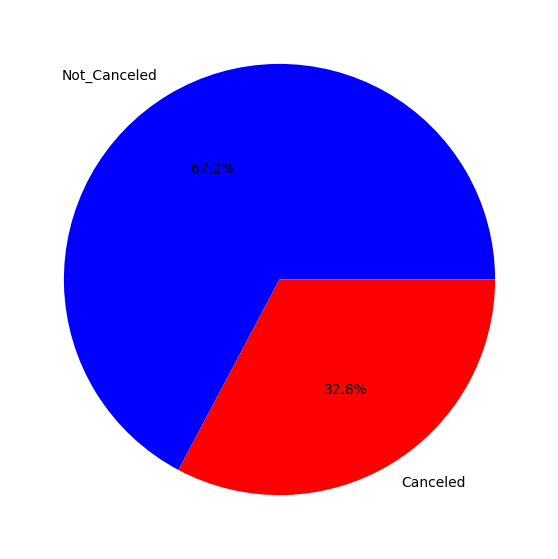

In [94]:
plt.figure(figsize=(7,7))
plt.pie(df["booking_status"].value_counts(), labels = ["Not_Canceled","Canceled"], colors= ['blue','red'],autopct='%3.1f%%')

In [95]:
df_EDA = pd.DataFrame(X_train)

encoding of objective values to categorical

<Figure size 640x480 with 0 Axes>

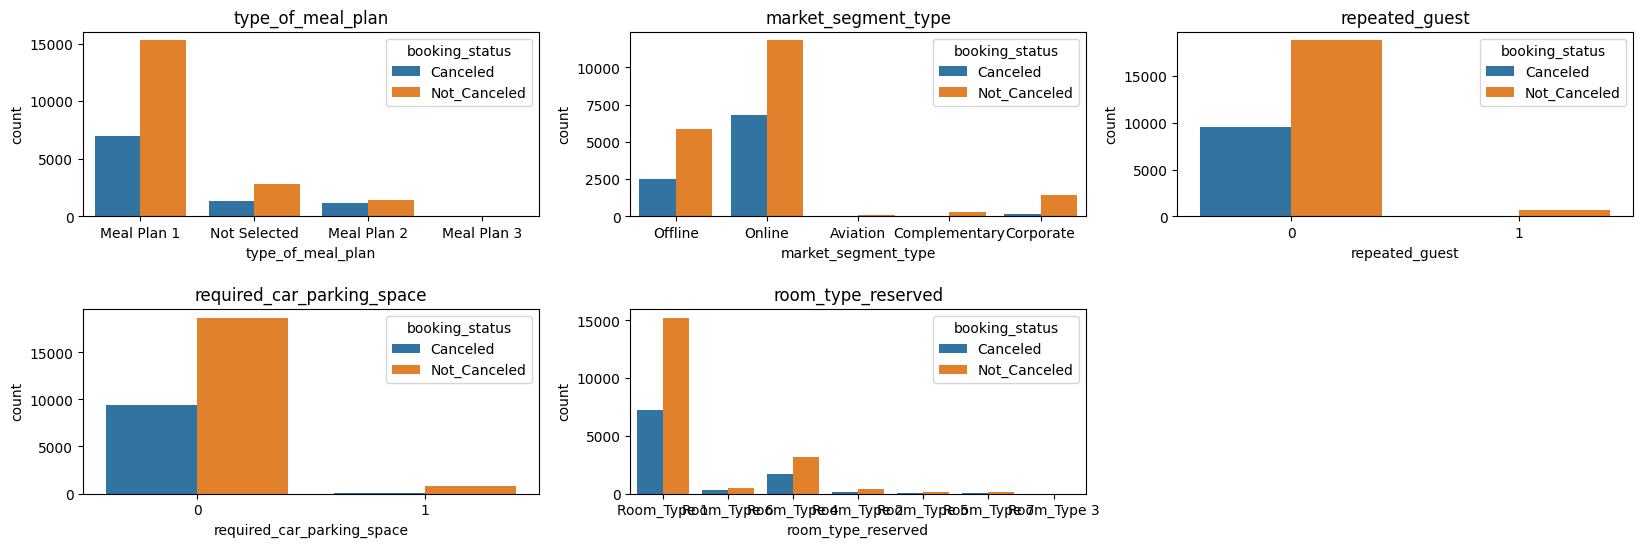

In [96]:
plt.figure()
plt.figure(figsize=(20,6))
plot_categorical_features(df_EDA, low_count_categorical_features, "booking_status",3)


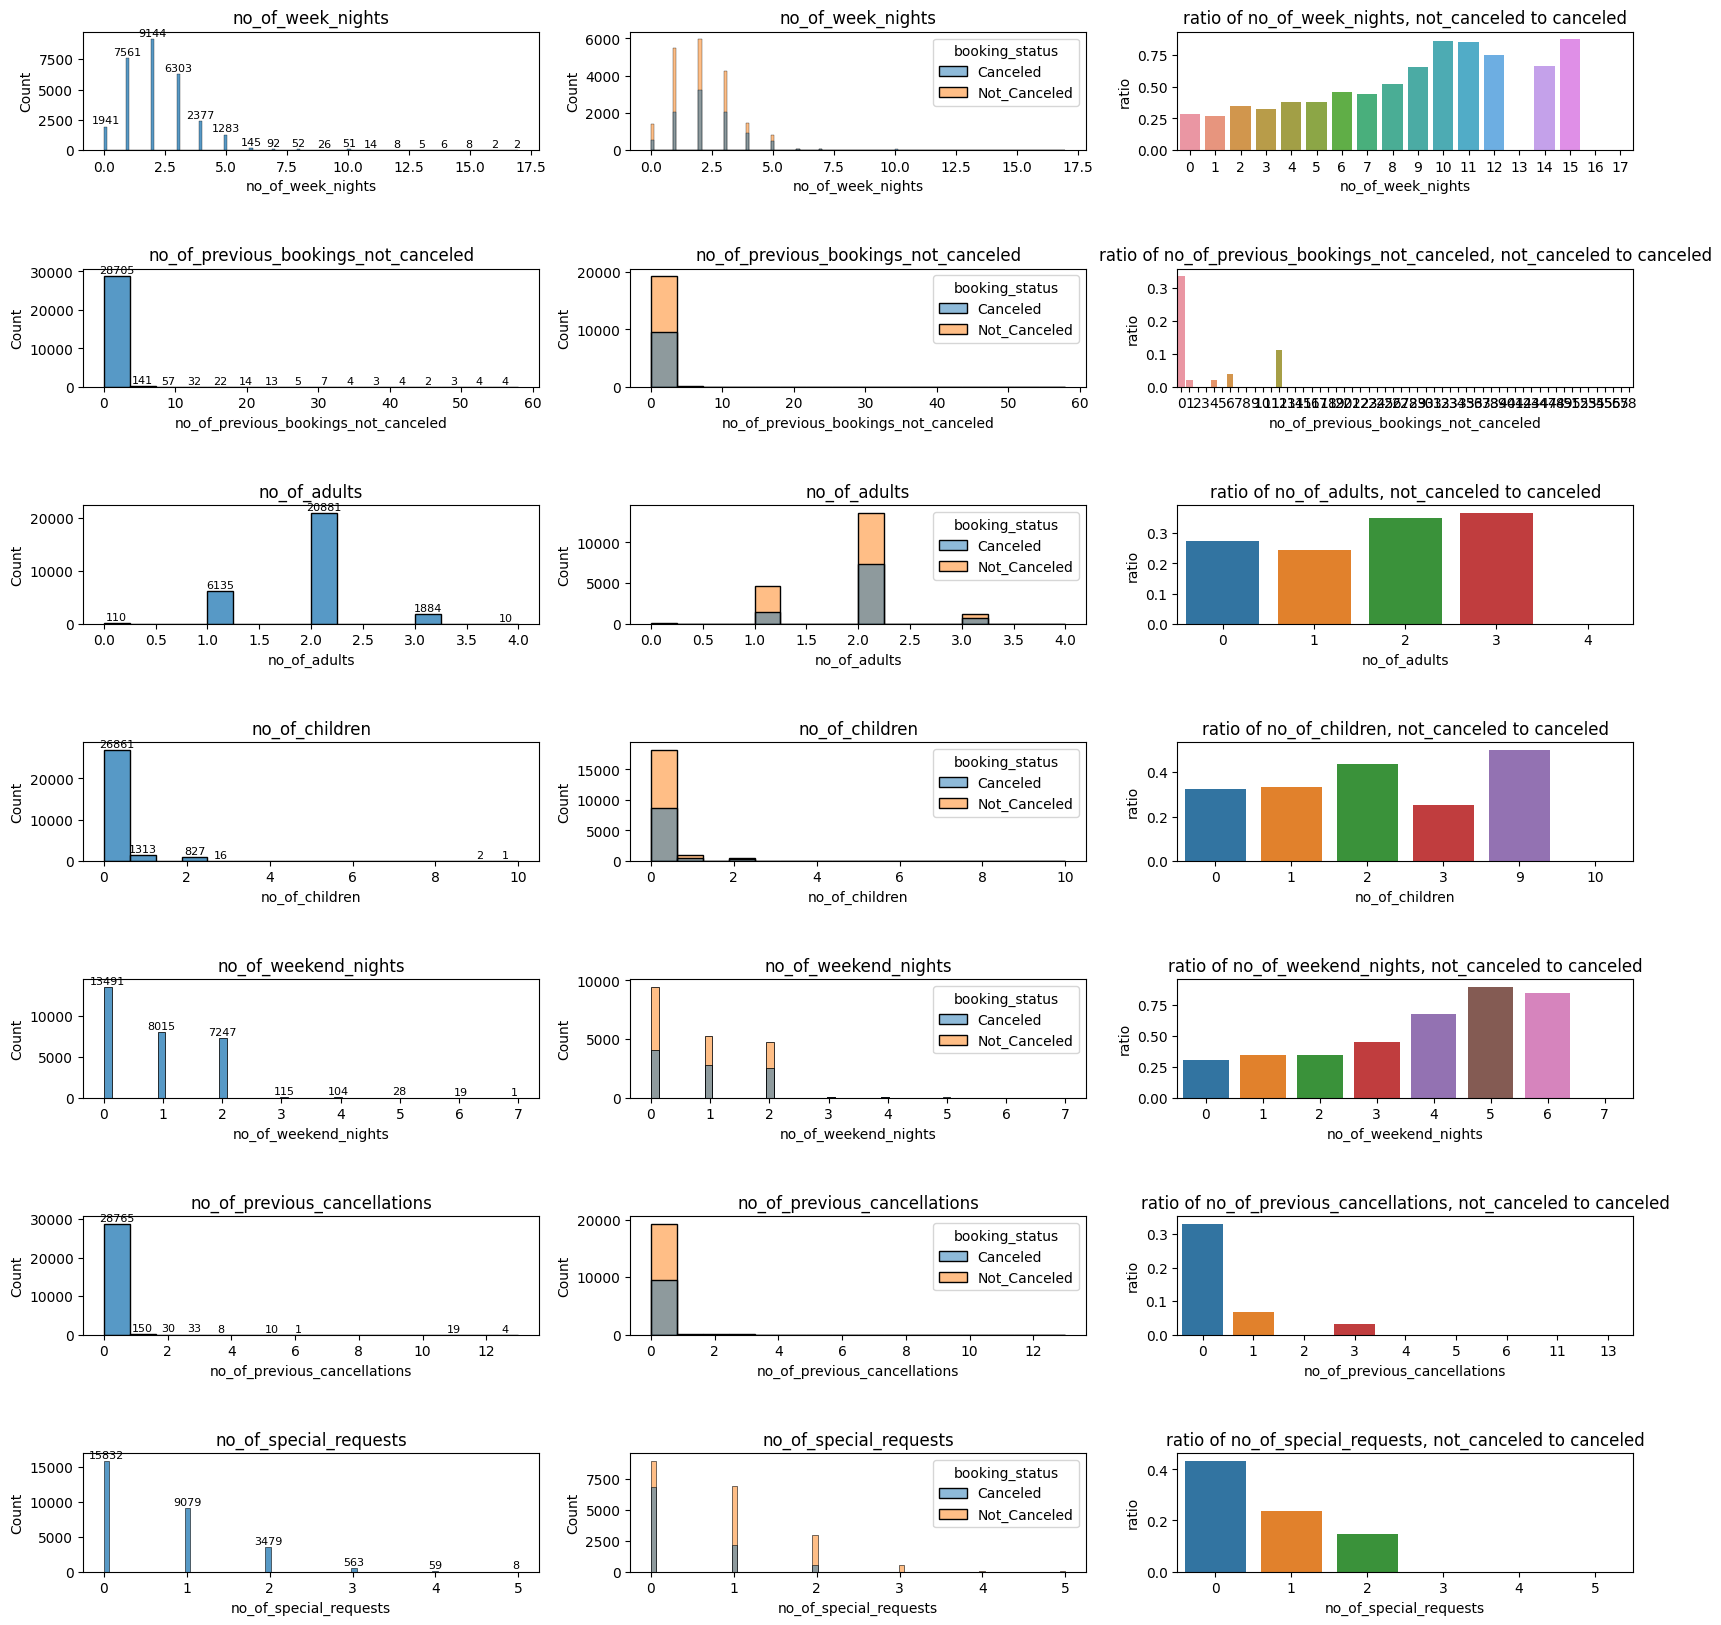

In [97]:
plot_ordinal_features(df_EDA, high_count_categorical_features, "booking_status")

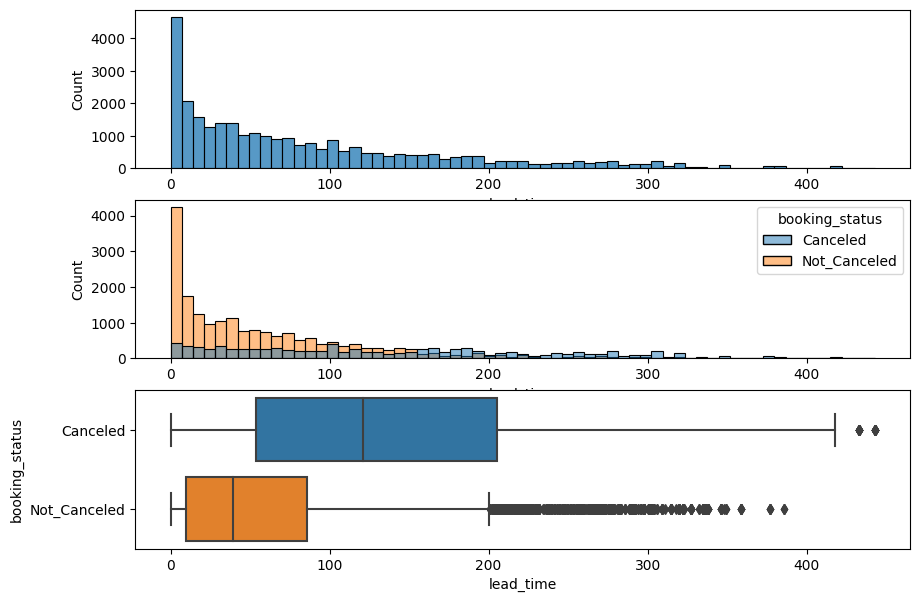

In [98]:
fig, ax = plt.subplots(3, figsize=(10, 7))

t = sns.histplot(data=df_EDA, x="lead_time", ax=ax[0])
t = sns.histplot(data=df_EDA, x="lead_time", ax=ax[1], hue="booking_status")
t = sns.boxplot(x="lead_time", y="booking_status", orient="h", data=df_EDA, ax=ax[2])

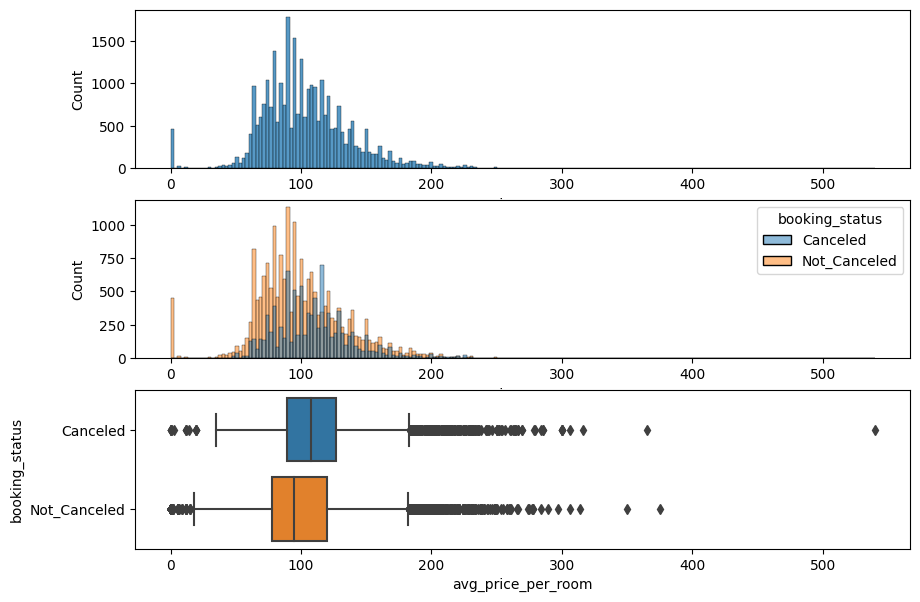

In [99]:
fig, ax = plt.subplots(3, figsize=(10, 7))

t = sns.histplot(data=df_EDA, x="avg_price_per_room", ax=ax[0])
t = sns.histplot(data=df_EDA, x="avg_price_per_room", ax=ax[1], hue="booking_status")
t = sns.boxplot(x="avg_price_per_room", y="booking_status", orient="h", data=df_EDA, ax=ax[2])

<AxesSubplot: xlabel='lead_time', ylabel='avg_price_per_room'>

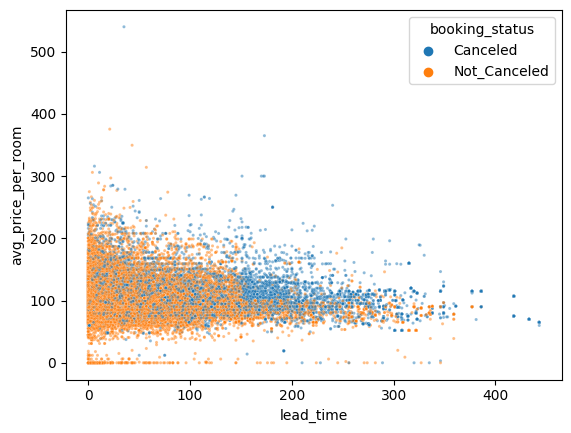

In [100]:
sns.scatterplot(data=df_EDA, x="lead_time", y="avg_price_per_room", hue="booking_status",s=5,alpha=0.5)

In [101]:
df_EDA['arrival_date']=df_EDA.apply(lambda row: 28 if (row['arrival_month'] == 2 and row['arrival_date'] > 28) else row['arrival_date'], axis=1)
df_EDA['complete_arrival_date']=df_EDA.apply(lambda x: datetime.date(x['arrival_year'], x['arrival_month'], x['arrival_date']), axis=1)

In [102]:
# Add a column with the count of cancellations per date
df_EDA["count"] = 1
canceled_df = df_EDA[df_EDA["booking_status"]=="Canceled"].groupby("complete_arrival_date")["count"].sum()
#cancelled_df =pd.DataFrame(cancelled_df)
not_canceled_df = df_EDA[df_EDA["booking_status"]=="Not_Canceled"].groupby("complete_arrival_date")["count"].sum()
#not_cancelled_df =pd.DataFrame(not_cancelled_df)

# Create a new dataframe with the ratio of cancelled bookings
result = pd.concat([canceled_df, not_canceled_df], axis=1)
result.columns = ['canceled', 'not_canceled']
result['canceled'].fillna(1)
result["ratio"] = result["not_canceled"] / (result["canceled"] + result["not_canceled"])
result =pd.DataFrame(result)

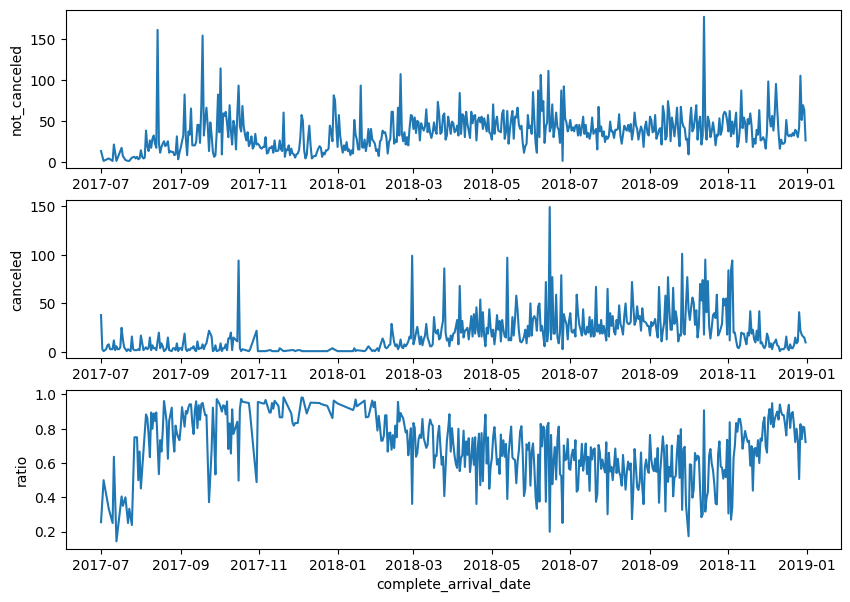

In [103]:
fig, ax = plt.subplots(3, figsize=(10, 7))

t = sns.lineplot(data=result, x="complete_arrival_date", y="not_canceled", ax=ax[0])
t = sns.lineplot(data=result, x="complete_arrival_date", y="canceled", ax=ax[1])
t = sns.lineplot(data=result, x="complete_arrival_date", y="ratio", ax=ax[2])

In [104]:
df_EDA['complete_arrival_date']=df_EDA.apply(lambda x: datetime.date(x['arrival_year'], x['arrival_month'],1), axis=1)

In [105]:
# Add a column with the count of cancellations per date
df_EDA["count"] = 1
canceled_df = df_EDA[df_EDA["booking_status"]=="Canceled"].groupby("complete_arrival_date")["count"].sum()
#cancelled_df =pd.DataFrame(cancelled_df)
not_canceled_df = df_EDA[df_EDA["booking_status"]=="Not_Canceled"].groupby("complete_arrival_date")["count"].sum()
#not_cancelled_df =pd.DataFrame(not_cancelled_df)

# Create a new dataframe with the ratio of cancelled bookings
result = pd.concat([canceled_df, not_canceled_df], axis=1)
result.columns = ['canceled', 'not_canceled']
result['canceled'].fillna(1)
result["ratio"] = result["not_canceled"] / (result["canceled"] + result["not_canceled"])
result =pd.DataFrame(result)

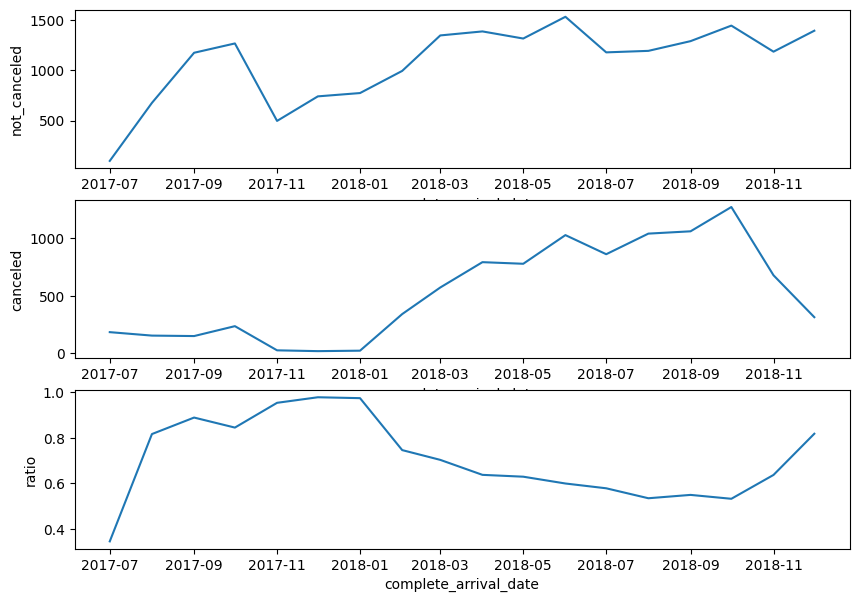

In [106]:
fig, ax = plt.subplots(3, figsize=(10, 7))

t = sns.lineplot(data=result, x="complete_arrival_date", y="not_canceled", ax=ax[0])
t = sns.lineplot(data=result, x="complete_arrival_date", y="canceled", ax=ax[1])
t = sns.lineplot(data=result, x="complete_arrival_date", y="ratio", ax=ax[2])

<AxesSubplot: xlabel='room_type_reserved', ylabel='type_of_meal_plan'>

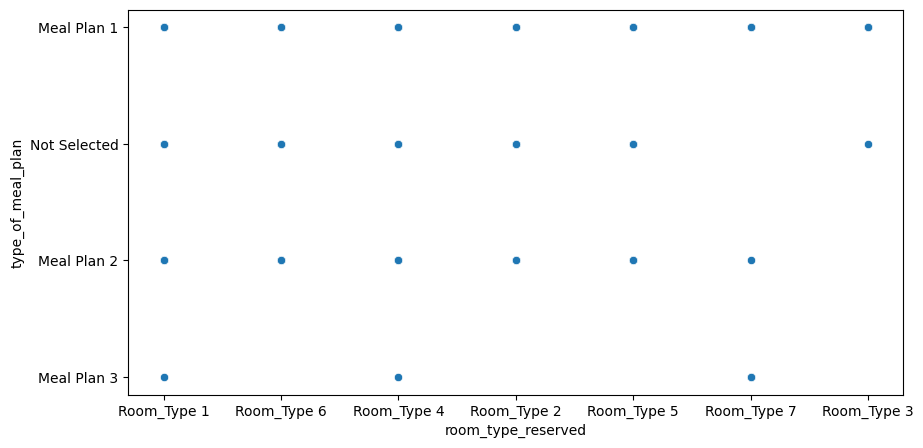

In [108]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x = "room_type_reserved", y="type_of_meal_plan",  data= df_EDA)

In [109]:
df_EDA['overall_people'] = df_EDA['no_of_children'] + df_EDA['no_of_adults']
df_EDA['overall_nights'] = df_EDA['no_of_weekend_nights'] + df_EDA['no_of_week_nights']
df_EDA['overall_price'] = df_EDA['avg_price_per_room'] * df_EDA['overall_nights']
df_EDA['average_price_per_room_person'] = df_EDA['avg_price_per_room'] / df_EDA['overall_people']

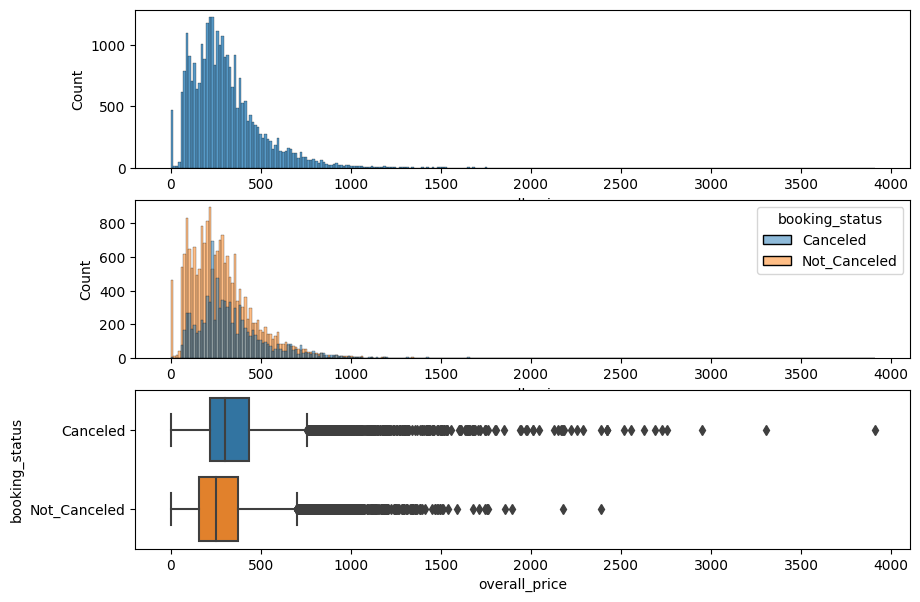

In [110]:
fig, ax = plt.subplots(3, figsize=(10, 7))

t = sns.histplot(data=df_EDA, x="overall_price", ax=ax[0])
t = sns.histplot(data=df_EDA, x="overall_price", ax=ax[1], hue="booking_status")
t = sns.boxplot(x="overall_price", y="booking_status", orient="h", data=df_EDA, ax=ax[2])

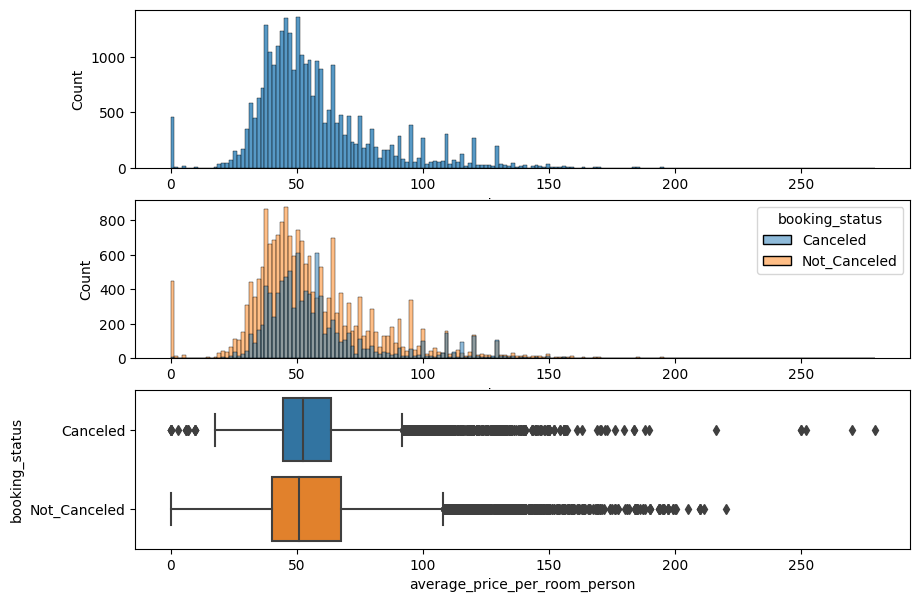

In [111]:
fig, ax = plt.subplots(3, figsize=(10, 7))

t = sns.histplot(data=df_EDA, x='average_price_per_room_person', ax=ax[0])
t = sns.histplot(data=df_EDA, x='average_price_per_room_person', ax=ax[1], hue="booking_status")
t = sns.boxplot(x='average_price_per_room_person', y="booking_status", orient="h", data=df_EDA, ax=ax[2])

In [112]:
df_EDA.agg(
    {
       "avg_price_per_room": ["min", "max", "median","mean", "skew", 'std'],
        "lead_time": ["min", "max", "median", "mean","skew",'std'],
        "overall_people": ["min", "max", "median", "mean","skew",'std'],
        "overall_nights": ["min", "max", "median", "mean","skew",'std'],
        'overall_price': ["min", "max", "median", "mean","skew",'std'],
        'average_price_per_room_person': ["min", "max", "median", "mean","skew",'std']
    }
)

,avg_price_per_room,lead_time,overall_people,overall_nights,overall_price,average_price_per_room_person
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,540.000000,443.000000,12.000000,24.000000,3910.000000,279.200000
median,99.900000,57.000000,2.000000,3.000000,270.000000,51.750000
mean,103.533282,85.127016,1.951482,3.014163,313.152604,57.587991
skew,0.674572,1.302642,0.894121,2.279979,2.577946,1.438188
std,35.147072,85.921809,0.650614,1.794301,219.976723,25.551952


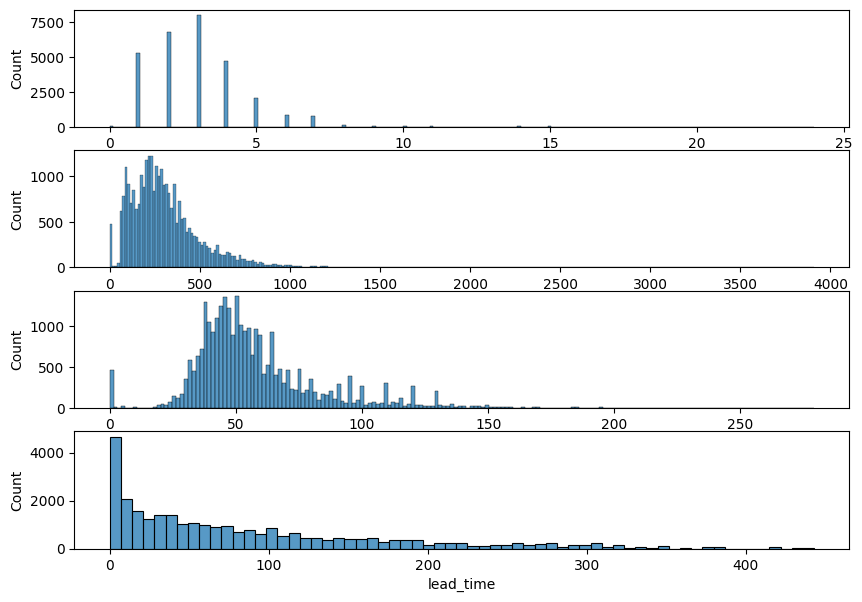

In [113]:
fig, ax = plt.subplots(4, figsize=(10, 7))
t = sns.histplot(df_EDA["overall_nights"], ax=ax[0])
t = sns.histplot(df_EDA["overall_price"], ax=ax[1])
t = sns.histplot(df_EDA["average_price_per_room_person"], ax=ax[2])
t = sns.histplot(df_EDA["lead_time"], ax=ax[3])

 Funktion für skewness erstellen

In [115]:
def reduce_skewness(df, skewed_feature):
    from scipy.stats import boxcox
    # This function chooses and applies the best method for skewness reduction
    # create a new DataFrame with the skewed feature and add several transformations
    df_skewness = pd.DataFrame({skewed_feature:df[skewed_feature]})
    df_skewness[skewed_feature+"_log"]=np.log(df[skewed_feature])
    df_skewness[skewed_feature+"_sqrt"] = df[skewed_feature]**(.5)
    df_skewness[skewed_feature+"_reciprocal"] = 1/df[skewed_feature]
    if ~np.any(df_skewness[skewed_feature] <= 0):
        df_skewness[skewed_feature+"_boxcox"] = df[skewed_feature], lmbda = boxcox(df[skewed_feature], lmbda=None)

    # Prints the new skewness, a histplot and returns the column with the smallest skewness
    skew_new = np.argmin(abs(df_skewness.skew()))
    print(f"{round(df_skewness[skewed_feature].skew(),2)}-->{round((df_skewness.iloc[:,skew_new]).skew(),2)}\nUsed method: {df_skewness.columns[skew_new]}")
    plt.figure(figsize=(8, 3))
    sns.histplot(df_skewness.iloc[:,skew_new])
    return df_skewness.iloc[:,skew_new]

c:\Users\jannis.ebling\Miniconda3\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


2.28-->0.62 
 Used method: overall_nights_sqrt


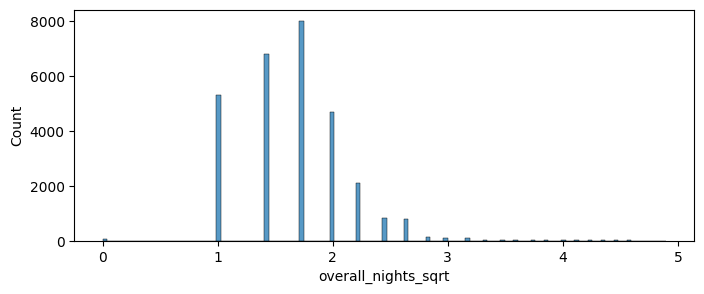

In [116]:
df_EDA["overall_nights"] = reduce_skewness(df_EDA,"overall_nights")

c:\Users\jannis.ebling\Miniconda3\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


2.58-->0.48 
 Used method: overall_price_sqrt


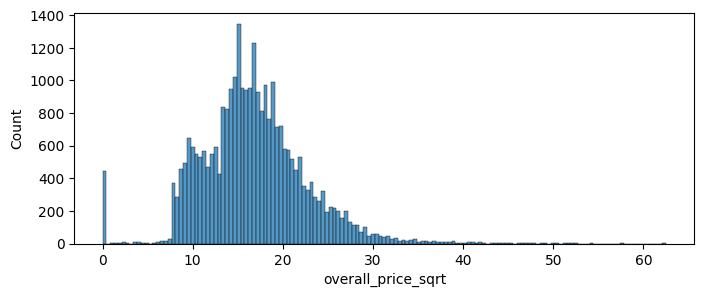

In [117]:
df_EDA["overall_price"] = reduce_skewness(df_EDA,"overall_price")

c:\Users\jannis.ebling\Miniconda3\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


1.44-->-0.44 
 Used method: average_price_per_room_person_sqrt


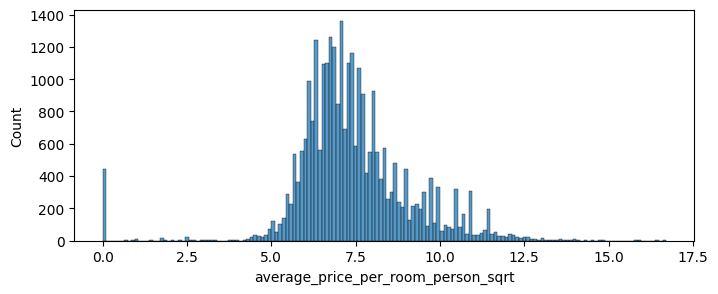

In [118]:

df_EDA["average_price_per_room_person"] = reduce_skewness(df_EDA,"average_price_per_room_person")

c:\Users\jannis.ebling\Miniconda3\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


1.3-->0.33 
 Used method: lead_time_sqrt


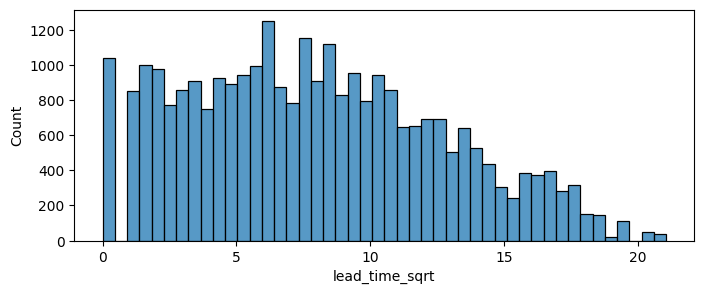

In [119]:
df_EDA["lead_time"] = reduce_skewness(df_EDA,"lead_time")

Feature selection

In [134]:
pd.set_option('display.max_columns', None)
df_EDA.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,complete_arrival_date,count,overall_people,overall_nights,overall_price,average_price_per_room_person
9078,INN09079,2,0,1,2,Meal Plan 1,0,Room_Type 1,16.522712,2018,5,13,Offline,0,0,0,95.00,0,Canceled,2018-05-01,1,2,1.732051,16.881943,6.892024
36042,INN36043,2,0,1,3,Meal Plan 1,0,Room_Type 1,12.569805,2018,6,30,Online,0,0,0,90.95,1,Canceled,2018-06-01,1,2,2.000000,19.073542,6.743515
5929,INN05930,2,0,2,1,Meal Plan 1,0,Room_Type 1,7.681146,2018,11,26,Online,0,0,0,93.60,1,Not_Canceled,2018-11-01,1,2,1.732051,16.757088,6.841053
6928,INN06929,1,0,0,2,Meal Plan 1,0,Room_Type 1,2.236068,2018,10,25,Aviation,0,0,0,95.00,0,Not_Canceled,2018-10-01,1,1,1.414214,13.784049,9.746794
34607,INN34608,2,2,2,4,Meal Plan 1,0,Room_Type 6,7.348469,2018,4,29,Online,0,0,0,187.85,0,Canceled,2018-04-01,1,4,2.449490,33.572310,6.852919


In [165]:
y_train = df_EDA["booking_status"]
df_prep = df_EDA.drop(["Booking_ID", "count", "booking_status", "complete_arrival_date"], axis=1)

In [155]:
df_prep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29020 entries, 9078 to 29823
Data columns (total 22 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   no_of_adults                          29020 non-null  int64  
 1   no_of_children                        29020 non-null  int64  
 2   no_of_weekend_nights                  29020 non-null  int64  
 3   no_of_week_nights                     29020 non-null  int64  
 4   type_of_meal_plan                     29020 non-null  object 
 5   required_car_parking_space            29020 non-null  int64  
 6   room_type_reserved                    29020 non-null  object 
 7   lead_time                             29020 non-null  float64
 8   arrival_year                          29020 non-null  int64  
 9   arrival_month                         29020 non-null  int64  
 10  arrival_date                          29020 non-null  int64  
 11  market_segme

In [166]:
y_train.replace({"Not_Canceled": 1, "Canceled": 0}, inplace=True)

In [167]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([
        ("cat_encoder", OneHotEncoder(sparse=False)),
        ("scaler", StandardScaler())
])
pipeline = Pipeline([
        ("scaler", StandardScaler())
    ])


In [172]:
all_features = list(df_prep.columns[0:-1])
unencoded_categorical_features = ["type_of_meal_plan", "market_segment_type", "room_type_reserved"]
encoded_features = [x for x in all_features if x not in unencoded_categorical_features]

In [174]:
from sklearn.compose import ColumnTransformer

preprocess_pipeline = ColumnTransformer([
        ("cat", cat_pipeline, unencoded_categorical_features),
        ("en", pipeline, encoded_features)
    ])


In [175]:
# Fit and transform the column of categorical data
df_prep = preprocess_pipeline.fit_transform(df_prep)


c:\Users\jannis.ebling\Miniconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[ 0.55208464, -0.31746684, -0.01312725, ...,  0.07457437,
         0.13233867,  0.02751879],
       [ 0.55208464, -0.31746684, -0.01312725, ...,  0.07457437,
         0.69106926,  0.40613853],
       [ 0.55208464, -0.31746684, -0.01312725, ...,  0.07457437,
         0.13233867,  0.0059489 ],
       ...,
       [ 0.55208464, -0.31746684, -0.01312725, ...,  0.07457437,
        -0.53041902, -0.36174385],
       [-1.81131648,  3.14993533, -0.01312725, ..., -1.46246271,
        -0.53041902, -0.61014328],
       [ 0.55208464, -0.31746684, -0.01312725, ...,  1.61161145,
         0.13233867,  1.33107644]])

In [176]:
df_prep.shape


(29020, 33)

Pipeline erstellen

In [178]:
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

rfe = RFECV(estimator=DecisionTreeClassifier())
model = DecisionTreeClassifier()
pipeline_rfe = Pipeline(steps=[("s",rfe), ("m",model)])
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline_rfe, df_prep, y_train, scoring="accuracy", cv=cv, n_jobs=-1)

In [179]:
print("Accuracy: %.3f (%.3f)" % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.863 (0.006)


In [186]:
rfe.fit(df_prep, y_train)


RFECV(estimator=DecisionTreeClassifier())

In [187]:
for i in range(df_prep.shape[1]):
    print("Column: %d, Selected=%s, Rank:%d" % (i, rfe.support_[i], rfe.ranking_[i]))

Column: 0, Selected=True, Rank:1
Column: 1, Selected=True, Rank:1
Column: 2, Selected=False, Rank:3
Column: 3, Selected=True, Rank:1
Column: 4, Selected=True, Rank:1
Column: 5, Selected=False, Rank:2
Column: 6, Selected=True, Rank:1
Column: 7, Selected=True, Rank:1
Column: 8, Selected=True, Rank:1
Column: 9, Selected=True, Rank:1
Column: 10, Selected=True, Rank:1
Column: 11, Selected=False, Rank:5
Column: 12, Selected=True, Rank:1
Column: 13, Selected=True, Rank:1
Column: 14, Selected=True, Rank:1
Column: 15, Selected=True, Rank:1
Column: 16, Selected=True, Rank:1
Column: 17, Selected=True, Rank:1
Column: 18, Selected=True, Rank:1
Column: 19, Selected=True, Rank:1
Column: 20, Selected=True, Rank:1
Column: 21, Selected=True, Rank:1
Column: 22, Selected=True, Rank:1
Column: 23, Selected=True, Rank:1
Column: 24, Selected=True, Rank:1
Column: 25, Selected=True, Rank:1
Column: 26, Selected=False, Rank:4
Column: 27, Selected=True, Rank:1
Column: 28, Selected=True, Rank:1
Column: 29, Selected

In [189]:
df_prep = pd.DataFrame(df_prep)
selected_features = df_prep.loc[:,rfe.support_]

In [190]:
selected_features

,0,1,3,4,6,7,8,9,10,12,13,14,15,16,17,18,19,20,21,22,23,24,25,27,28,29,30,31,32
0,0.552085,-0.317467,-0.406597,-0.059682,-0.242518,1.569265,-1.337051,0.538417,-0.138475,-0.448618,-0.0878,-0.164434,-0.065242,0.295534,-0.260339,0.216967,-0.143673,-0.180332,1.818345,0.468215,-0.792172,-0.295628,-0.162657,-0.087935,-0.242792,-0.786807,0.074574,0.132339,0.027519
1,0.552085,-0.317467,-0.406597,-0.059682,-0.242518,-0.637241,0.747915,0.538417,-0.138475,-0.448618,-0.0878,-0.164434,-0.065242,0.295534,-0.260339,0.216967,0.563005,-0.180332,0.982663,0.468215,-0.466441,1.652374,-0.162657,-0.087935,-0.358024,0.481560,0.074574,0.691069,0.406139
2,0.552085,-0.317467,-0.406597,-0.059682,-0.242518,-0.637241,0.747915,0.538417,-0.138475,-0.448618,-0.0878,-0.164434,-0.065242,0.295534,-0.260339,1.364056,-0.850351,-0.180332,-0.050846,0.468215,1.162218,1.194021,-0.162657,-0.087935,-0.282625,0.481560,0.074574,0.132339,0.005949
3,0.552085,-0.317467,-0.406597,16.755524,-0.242518,-0.637241,-1.337051,0.538417,-0.138475,-0.448618,-0.0878,-0.164434,-0.065242,-1.631314,-0.260339,-0.930123,-0.143673,-0.180332,-1.201988,0.468215,0.836486,1.079432,-0.162657,-0.087935,-0.242792,-0.786807,-1.462463,-0.530419,-0.507672
4,0.552085,-0.317467,-0.406597,-0.059682,-0.242518,-0.637241,0.747915,-1.857298,-0.138475,-0.448618,-0.0878,6.081471,-0.065242,0.295534,4.705177,1.364056,1.269682,-0.180332,-0.121177,0.468215,-1.117904,1.537786,-0.162657,-0.087935,2.399010,-0.786807,3.148649,1.628350,2.910940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29015,0.552085,-0.317467,-0.406597,-0.059682,-0.242518,-0.637241,0.747915,-1.857298,-0.138475,2.229066,-0.0878,-0.164434,-0.065242,0.295534,2.222419,0.216967,-0.143673,-0.180332,0.342005,0.468215,-0.792172,-0.295628,-0.162657,-0.087935,1.048945,-0.786807,1.611611,0.132339,0.656574
29016,0.552085,-0.317467,-0.406597,-0.059682,-0.242518,-0.637241,0.747915,0.538417,-0.138475,-0.448618,-0.0878,-0.164434,-0.065242,0.295534,-0.260339,-0.930123,0.563005,-0.180332,0.003297,0.468215,0.185023,-0.753981,-0.162657,-0.087935,1.154219,-0.786807,0.074574,0.132339,0.702988
29017,0.552085,-0.317467,-0.406597,-0.059682,-0.242518,-0.637241,0.747915,0.538417,-0.138475,-0.448618,-0.0878,-0.164434,-0.065242,0.295534,-0.260339,-0.930123,-0.143673,-0.180332,-0.829076,-2.135771,0.836486,-1.670688,-0.162657,-0.087935,0.098636,-0.786807,0.074574,-0.530419,-0.361744
29018,-1.811316,3.149935,-0.406597,-0.059682,-0.242518,1.569265,-1.337051,0.538417,-0.138475,-0.448618,-0.0878,-0.164434,-0.065242,-1.631314,-0.260339,-0.930123,-0.143673,-0.180332,1.818345,-2.135771,-0.140709,0.162726,-0.162657,-0.087935,-0.470411,-0.786807,-1.462463,-0.530419,-0.610143


Model ausprobieren